<p style="text-align:center">\n
    <a href="https://skills.network/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML321ENSkillsNetwork817-2022-01-01" target="_blank">\n
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo">\n
    </a>\n
</p>\n

# **Regression-based Rating Score Prediction using Embedding Features**

Estimated time needed: **45–60** minutes

From the neural CF lab you exported user/item embeddings. Here we treat the problem as a standard **regression** task: combine the two embedding vectors into a single feature vector **X**, and learn a mapping to the numeric rating **y**.

## Objectives

After completing this lab you will be able to:

* Build and evaluate linear models (Linear/Ridge/Lasso/ElasticNet) to predict ratings from combined embeddings
* Explore aggregation strategies (sum / product / concatenation)
* Save artifacts and metrics into your project structure

----
## Prepare and setup lab environment

Install required packages if needed.

In [1]:
%pip install -q scikit-learn pandas matplotlib joblib

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os, json
from pathlib import Path
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

# also set a random state
rs = 123
np.random.seed(rs)

### Project paths (respect your repo layout)

In [3]:
CWD = Path.cwd().resolve()
if CWD.name == 'notebooks' and (CWD.parent / 'data').exists():
    PROJECT_ROOT = CWD.parent
elif (CWD / 'data').exists():
    PROJECT_ROOT = CWD
else:
    PROJECT_ROOT = CWD  # fallback

DATA_DIR = PROJECT_ROOT / 'data'
EXTERNAL_DIR = DATA_DIR / 'external'
PROCESSED_DIR = DATA_DIR / 'processed'
REPORTS_FIG_DIR = PROJECT_ROOT / 'reports' / 'figures'
LOGS_DIR = PROJECT_ROOT / 'logs'
MODELS_DIR = PROJECT_ROOT / 'models'

for d in [EXTERNAL_DIR, PROCESSED_DIR, REPORTS_FIG_DIR, LOGS_DIR, MODELS_DIR]:
    d.mkdir(parents=True, exist_ok=True)

print('PROJECT_ROOT:', PROJECT_ROOT)

PROJECT_ROOT: /Users/villafuertech/Documents/Professional/Independent_learning/IBM_Machine_learning/Capstone_project/recsys-capstone


## Load datasets

In [4]:
# Prefer local rating CSV if present; otherwise use hosted fallback
rating_local = EXTERNAL_DIR / 'course_ratings.csv'
rating_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-ML0321EN-Coursera/labs/v2/module_3/ratings.csv"
rating_df = pd.read_csv(rating_local) if rating_local.exists() else pd.read_csv(rating_url)

# Prefer embeddings exported by the CF-ANN notebook; otherwise hosted fallbacks
user_emb_local = PROCESSED_DIR / 'user_embeddings_baseline.csv'
item_emb_local = PROCESSED_DIR / 'item_embeddings_baseline.csv'
user_emb_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/datasets/user_embeddings.csv"
item_emb_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/datasets/course_embeddings.csv"

user_emb_raw = pd.read_csv(user_emb_local) if user_emb_local.exists() else pd.read_csv(user_emb_url)
item_emb_raw = pd.read_csv(item_emb_local) if item_emb_local.exists() else pd.read_csv(item_emb_url)

rating_df = rating_df[['user','item','rating']].copy()
print('ratings:', rating_df.shape, '| user_emb:', user_emb_raw.shape, '| item_emb:', item_emb_raw.shape)
rating_df.head(3)

ratings: (233306, 3) | user_emb: (33901, 17) | item_emb: (126, 17)


,user,item,rating
0,1889878,CC0101EN,5
1,1342067,CL0101EN,3
2,1990814,ML0120ENv3,5


### Normalize embedding column names

We ensure the embedding DataFrames have a consistent format:
- user id column named `user`
- item id column named `item`
- feature columns named `UFeature0..` and `CFeature0..`

In [5]:
def normalize_user_emb(df):
    df = df.copy()
    id_col = 'user' if 'user' in df.columns else ('user_id' if 'user_id' in df.columns else None)
    assert id_col is not None, 'User embedding must include user or user_id column'
    feat_cols = [c for c in df.columns if c != id_col]
    rename_map = {id_col: 'user'}
    for i, c in enumerate(feat_cols):
        rename_map[c] = f'UFeature{i}'
    out = df.rename(columns=rename_map)
    return out, [f'UFeature{i}' for i in range(len(feat_cols))]

def normalize_item_emb(df):
    df = df.copy()
    id_col = 'item' if 'item' in df.columns else ('item_id' if 'item_id' in df.columns else None)
    assert id_col is not None, 'Item embedding must include item or item_id column'
    feat_cols = [c for c in df.columns if c != id_col]
    rename_map = {id_col: 'item'}
    for i, c in enumerate(feat_cols):
        rename_map[c] = f'CFeature{i}'
    out = df.rename(columns=rename_map)
    return out, [f'CFeature{i}' for i in range(len(feat_cols))]

user_emb, u_features = normalize_user_emb(user_emb_raw)
item_emb, c_features = normalize_item_emb(item_emb_raw)

print(len(u_features), 'user features |', len(c_features), 'item features')
display(user_emb.head(2))
display(item_emb.head(2))

16 user features | 16 item features


,user,UFeature0,UFeature1,UFeature2,UFeature3,UFeature4,UFeature5,UFeature6,UFeature7,UFeature8,UFeature9,UFeature10,UFeature11,UFeature12,UFeature13,UFeature14,UFeature15
0,1889878,0.033022,0.068657,0.004409,0.003708,0.064142,-0.034011,-0.027975,-0.002681,0.015392,-0.074402,0.020501,0.046947,0.067408,-0.027664,0.025213,-0.055095
1,1342067,-0.009976,-0.019721,-0.006740,0.005201,-0.032104,0.029420,0.030979,0.029344,-0.000229,-0.021921,-0.007147,-0.000556,-0.000393,-0.009939,-0.014357,0.021424


,item,CFeature0,CFeature1,CFeature2,CFeature3,CFeature4,CFeature5,CFeature6,CFeature7,CFeature8,CFeature9,CFeature10,CFeature11,CFeature12,CFeature13,CFeature14,CFeature15
0,CC0101EN,-0.172086,-0.033214,0.107699,0.231775,0.008553,-0.325155,0.177375,-0.036309,0.127059,0.129681,-0.134265,0.119908,0.119611,0.111782,-0.280107,-0.041800
1,CL0101EN,-0.037116,0.177518,-0.004479,0.133399,0.072230,0.015994,-0.054191,-0.181337,0.088625,0.157015,-0.133860,0.055236,-0.148096,-0.042896,0.122026,-0.078289


### Merge embeddings into the rating dataframe

In [6]:
merged = rating_df.merge(user_emb, on='user', how='left').merge(item_emb, on='item', how='left')
merged = merged.fillna(0)
print(merged.shape)
merged.head(3)

(233306, 35)


,user,item,rating,UFeature0,UFeature1,UFeature2,UFeature3,UFeature4,UFeature5,UFeature6,...,CFeature6,CFeature7,CFeature8,CFeature9,CFeature10,CFeature11,CFeature12,CFeature13,CFeature14,CFeature15
0,1889878,CC0101EN,5,0.033022,0.068657,0.004409,0.003708,0.064142,-0.034011,-0.027975,...,0.177375,-0.036309,0.127059,0.129681,-0.134265,0.119908,0.119611,0.111782,-0.280107,-0.041800
1,1342067,CL0101EN,3,-0.009976,-0.019721,-0.006740,0.005201,-0.032104,0.029420,0.030979,...,-0.054191,-0.181337,0.088625,0.157015,-0.133860,0.055236,-0.148096,-0.042896,0.122026,-0.078289
2,1990814,ML0120ENv3,5,-0.078293,0.022187,0.010924,0.002994,0.018679,-0.044196,0.033823,...,-0.130364,0.094914,-0.096233,0.002598,-0.029295,0.035682,-0.102239,-0.131291,0.090083,-0.058062


### Build regression datasets (aggregation strategies)

We create three views of the combined features:

- **sum**: element-wise add user and item embeddings (size = k)
- **prod**: element-wise Hadamard product (size = k)
- **concat**: concatenation `[user_emb, item_emb]` (size = 2k)

In [7]:
U = merged[u_features].values.astype('float32')
C = merged[c_features].values.astype('float32')
y = merged['rating'].astype('float32').values

assert U.shape[1] == C.shape[1], 'User and item embedding dims must match for sum/prod'
k = U.shape[1]

X_sum = (U + C)
X_prod = (U * C)
X_concat = np.concatenate([U, C], axis=1)

def split(X, y, test_size=0.3, rs=rs):
    return train_test_split(X, y, test_size=test_size, random_state=rs)

Xy_sets = {}
for name, X in [('sum', X_sum), ('prod', X_prod), ('concat', X_concat)]:
    X_train, X_test, y_train, y_test = split(X, y)
    Xy_sets[name] = (X_train, X_test, y_train, y_test)
    print(name, '→ X:', X.shape, '| y:', y.shape)

sum → X: (233306, 16) | y: (233306,)
prod → X: (233306, 16) | y: (233306,)
concat → X: (233306, 32) | y: (233306,)


Quick look at unique rating values:

In [8]:
sorted(np.unique(y))

[np.float32(3.0), np.float32(4.0), np.float32(5.0)]

## Train & evaluate models

We will:
- Train a **LinearRegression** baseline
- Hyperparameter-tune **Ridge**, **Lasso**, **ElasticNet** via GridSearchCV
- Evaluate by **RMSE** on the test split
- Compare across aggregation strategies
- Save artifacts (metrics and best model)

In [9]:
def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

results = []
best_estimators = {}  # (agg, model) -> fitted estimator/pipeline

for agg_name, (X_train, X_test, y_train, y_test) in Xy_sets.items():
    # Baseline (global mean on train)
    baseline_pred = np.full_like(y_test, fill_value=y_train.mean(), dtype='float32')
    r_base = rmse(y_test, baseline_pred)
    results.append({'agg': agg_name, 'model': 'BaselineMean', 'rmse': r_base, 'best_params': {}})

    # 1) Linear Regression (no regularization) with StandardScaler
    lin = Pipeline([
        ('scaler', StandardScaler(with_mean=True, with_std=True)),
        ('model', LinearRegression())
    ])
    lin.fit(X_train, y_train)
    yhat = lin.predict(X_test)
    r_lin = rmse(y_test, yhat)
    results.append({'agg': agg_name, 'model': 'LinearRegression', 'rmse': r_lin, 'best_params': {}})
    best_estimators[(agg_name, 'LinearRegression')] = lin

    # 2) Ridge
    ridge = Pipeline([
        ('scaler', StandardScaler()),
        ('model', Ridge())
    ])
    ridge_grid = {'model__alpha': [0.01, 0.1, 1.0, 3.0, 10.0, 30.0]}
    ridge_cv = GridSearchCV(ridge, ridge_grid, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)
    ridge_cv.fit(X_train, y_train)
    yhat = ridge_cv.predict(X_test)
    r_ridge = rmse(y_test, yhat)
    results.append({'agg': agg_name, 'model': 'Ridge', 'rmse': r_ridge, 'best_params': ridge_cv.best_params_})
    best_estimators[(agg_name, 'Ridge')] = ridge_cv.best_estimator_

    # 3) Lasso
    lasso = Pipeline([
        ('scaler', StandardScaler()),
        ('model', Lasso(max_iter=5000))
    ])
    lasso_grid = {'model__alpha': [1e-4, 5e-4, 1e-3, 1e-2, 1e-1, 1.0]}
    lasso_cv = GridSearchCV(lasso, lasso_grid, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)
    lasso_cv.fit(X_train, y_train)
    yhat = lasso_cv.predict(X_test)
    r_lasso = rmse(y_test, yhat)
    results.append({'agg': agg_name, 'model': 'Lasso', 'rmse': r_lasso, 'best_params': lasso_cv.best_params_})
    best_estimators[(agg_name, 'Lasso')] = lasso_cv.best_estimator_

    # 4) ElasticNet
    enet = Pipeline([
        ('scaler', StandardScaler()),
        ('model', ElasticNet(max_iter=5000))
    ])
    enet_grid = {
        'model__alpha': [1e-4, 5e-4, 1e-3, 1e-2, 1e-1, 1.0],
        'model__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
    }
    enet_cv = GridSearchCV(enet, enet_grid, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)
    enet_cv.fit(X_train, y_train)
    yhat = enet_cv.predict(X_test)
    r_enet = rmse(y_test, yhat)
    results.append({'agg': agg_name, 'model': 'ElasticNet', 'rmse': r_enet, 'best_params': enet_cv.best_params_})
    best_estimators[(agg_name, 'ElasticNet')] = enet_cv.best_estimator_

results_df = pd.DataFrame(results).sort_values(['agg','rmse']).reset_index(drop=True)
results_df

/Users/villafuertech/.venvs/jlab/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.112e+01, tolerance: 7.267e+00
  model = cd_fast.enet_coordinate_descent(


,agg,model,rmse,best_params
0,concat,LinearRegression,0.800425,{}
1,concat,Ridge,0.800426,{'model__alpha': 30.0}
2,concat,Lasso,0.800517,{'model__alpha': 0.0005}
3,concat,ElasticNet,0.800694,"{'model__alpha': 0.01, 'model__l1_ratio': 0.1}"
4,concat,BaselineMean,0.813818,{}
5,prod,Ridge,0.556259,{'model__alpha': 0.01}
6,prod,LinearRegression,0.556263,{}
7,prod,ElasticNet,0.556270,"{'model__alpha': 0.0001, 'model__l1_ratio': 0.1}"
8,prod,Lasso,0.556306,{'model__alpha': 0.0001}
9,prod,BaselineMean,0.813818,{}


### Save metrics table

In [10]:
metrics_csv = PROCESSED_DIR / 'regression_results.csv'
results_df.to_csv(metrics_csv, index=False)
print('Saved:', metrics_csv)

Saved: /Users/villafuertech/Documents/Professional/Independent_learning/IBM_Machine_learning/Capstone_project/recsys-capstone/data/processed/regression_results.csv


### Plot RMSE by model and aggregation

Saved plot to: /Users/villafuertech/Documents/Professional/Independent_learning/IBM_Machine_learning/Capstone_project/recsys-capstone/reports/figures/regression_rmse_by_model.png


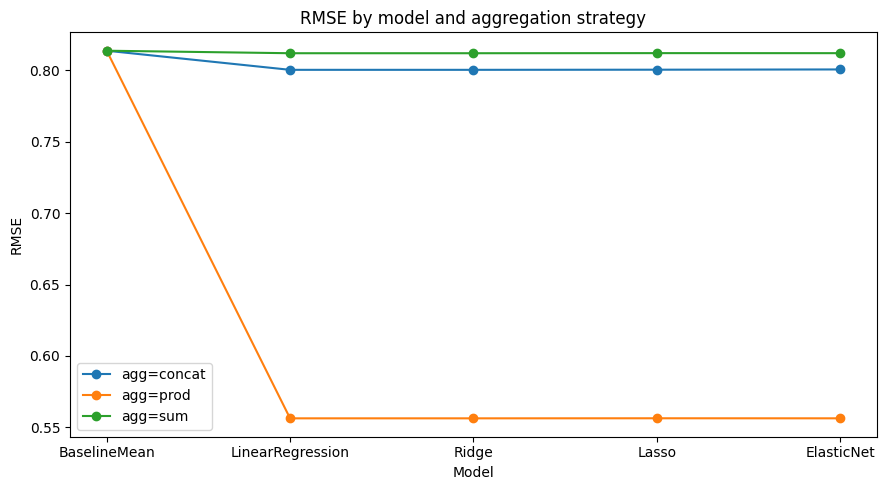

In [11]:
plt.figure(figsize=(9,5))
order = ['BaselineMean','LinearRegression','Ridge','Lasso','ElasticNet']
plot_df = results_df.copy()
plot_df['model'] = pd.Categorical(plot_df['model'], categories=order, ordered=True)
for i, agg in enumerate(sorted(plot_df['agg'].unique())):
    sub = plot_df[plot_df['agg']==agg].sort_values('model')
    plt.plot(sub['model'], sub['rmse'], marker='o', label=f'agg={agg}')
plt.ylabel('RMSE')
plt.xlabel('Model')
plt.title('RMSE by model and aggregation strategy')
plt.legend()
fig_path = REPORTS_FIG_DIR / 'regression_rmse_by_model.png'
plt.tight_layout()
plt.savefig(fig_path, dpi=150)
print('Saved plot to:', fig_path)
plt.show()

### Pick and save the best model

In [12]:
best_row = results_df.loc[results_df['rmse'].idxmin()].to_dict()
best_row

{'agg': 'prod',
 'model': 'Ridge',
 'rmse': 0.5562593727179408,
 'best_params': {'model__alpha': 0.01}}

In [13]:
best_agg = best_row['agg']
best_model_name = best_row['model']
if best_model_name == 'BaselineMean':
    # for completeness, we keep a simple dict with the mean
    # but usually you'd prefer a learned model
    X_train, X_test, y_train, y_test = Xy_sets[best_agg]
    artifact = {'type': 'baseline_mean', 'mean': float(y_train.mean()), 'agg': best_agg}
    model_path = MODELS_DIR / f'best_model_{best_agg}_baseline_mean.json'
    with open(model_path, 'w') as f:
        json.dump(artifact, f, indent=2)
else:
    best_est = best_estimators[(best_agg, best_model_name)]
    model_path = MODELS_DIR / f'best_model_{best_agg}_{best_model_name}.joblib'
    joblib.dump(best_est, model_path)

meta = {
    'timestamp': datetime.utcnow().isoformat() + 'Z',
    'best': best_row,
    'model_path': str(model_path)
}
meta_path = LOGS_DIR / 'regression_experiment_meta.json'
with open(meta_path, 'w') as f:
    json.dump(meta, f, indent=2)
print('Saved best model/meta to:', model_path, '|', meta_path)

Saved best model/meta to: /Users/villafuertech/Documents/Professional/Independent_learning/IBM_Machine_learning/Capstone_project/recsys-capstone/models/best_model_prod_Ridge.joblib | /Users/villafuertech/Documents/Professional/Independent_learning/IBM_Machine_learning/Capstone_project/recsys-capstone/logs/regression_experiment_meta.json


/var/folders/q0/bm9058_95z16l6j28pkf1z580000gn/T/ipykernel_72978/2431981481.py:17: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  'timestamp': datetime.utcnow().isoformat() + 'Z',


## Optional: Inspect coefficients / feature importance (linear models)

In [14]:
if best_model_name in ['LinearRegression','Ridge','Lasso','ElasticNet']:
    # unwrap pipeline: scaler + model
    best_est = best_estimators[(best_agg, best_model_name)]
    model = best_est.named_steps['model']
    # Build feature names for the chosen aggregation
    if best_agg == 'concat':
        feat_names = [f'UFeature{i}' for i in range(k)] + [f'CFeature{i}' for i in range(k)]
    elif best_agg == 'sum':
        feat_names = [f'SumFeature{i}' for i in range(k)]
    else:
        feat_names = [f'ProdFeature{i}' for i in range(k)]
    coefs = pd.Series(model.coef_.ravel() if hasattr(model, 'coef_') else [], index=feat_names[:len(model.coef_.ravel())])
    coef_csv = PROCESSED_DIR / f'coefficients_{best_agg}_{best_model_name}.csv'
    coefs.to_csv(coef_csv)
    print('Top positive weights:')
    display(coefs.sort_values(ascending=False).head(10))
    print('Top negative weights:')
    display(coefs.sort_values(ascending=True).head(10))
    print('Saved:', coef_csv)

Top positive weights:


ProdFeature2     0.104865
ProdFeature8     0.095988
ProdFeature7     0.093744
ProdFeature3     0.091327
ProdFeature14    0.086454
ProdFeature0     0.083782
ProdFeature12    0.083444
ProdFeature5     0.083186
ProdFeature1     0.079255
ProdFeature13    0.078948
dtype: float32

Top negative weights:


ProdFeature9     0.056637
ProdFeature11    0.056989
ProdFeature4     0.061215
ProdFeature15    0.067262
ProdFeature6     0.071686
ProdFeature10    0.075742
ProdFeature13    0.078948
ProdFeature1     0.079255
ProdFeature5     0.083186
ProdFeature12    0.083444
dtype: float32

Saved: /Users/villafuertech/Documents/Professional/Independent_learning/IBM_Machine_learning/Capstone_project/recsys-capstone/data/processed/coefficients_prod_Ridge.csv


## Summary

In this lab you:

- Merged **user** and **item** embeddings into rating rows
- Built three **feature aggregation** strategies (sum, product, concat)
- Trained **Linear/Ridge/Lasso/ElasticNet** models with proper scaling
- Tuned hyperparameters via **GridSearchCV**
- Evaluated with **RMSE**, compared to a **BaselineMean**
- Saved results to:
  - Metrics: `data/processed/regression_results.csv`
  - Plot: `reports/figures/regression_rmse_by_model.png`
  - Best model + metadata: `models/`, `logs/`

You can now load the saved model and score new `(user,item)` pairs by recreating the same aggregation (sum/prod/concat) of the corresponding embeddings and calling `predict()`.

## Authors

[Yan Luo](https://www.linkedin.com/in/yan-luo-96288783/)

### Change Log

|Date (YYYY-MM-DD)|Version|Changed By|Change Description|
|-|-|-|-|
|2021-10-25|1.0|Yan|Created the initial version|
|2025-10-05|1.1|You|Completed optional parts (multi-aggregation, GridSearchCV, plots, artifacts)|

Copyright © 2021–2025 IBM Corporation. All rights reserved.